In [1]:
%load_ext autoreload
%autoreload 2
    
import fiona
from pathlib import Path
import metapack as mp
import geopandas as gpd
import pandas as pd
import numpy as np
from auto_tqdm import tqdm 
import appnope

doc = mp.jupyter.open_source_package()
doc.set_sys_path()
import  pylib 

ea_epsg = 2163 #US Equal Area projection

import logging
logging.basicConfig()

from pylib import lines_logger, points_logger
lines_logger.setLevel(logging.DEBUG)
points_logger.setLevel(logging.DEBUG)

pkg_root = Path(doc.path).parent
pkg = mp.open_package(pkg_root)
cache = pylib.open_cache(pkg)
pkg


# Open Street Map Extract for Demographic Search
`civicknowledge.com-osm-demosearch-1.2.1` Last Update: 2021-02-15T17:38:34

__




 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [point_tags](data/point_tags.csv)**. Points converted to counts of tags per geohash
* ** [residential_roads](data/residential_roads.csv)**. Residential roads per 4 digit geohash
* ** [nonres_roads](data/nonres_roads.csv)**. Non residential roads per 4 digit geohash
* ** [block_geo](data/block_geo.csv)**. Geographic shapes for blocs in block_osm
* ** [block_osm](data/block_osm.csv)**. Points from geohash_tags allocated to 2020 census blocks
* ** [utm_map](data/utm_map.csv)**. Map from census blocks to UTM zones
* ** [cbsa_map](data/cbsa_map.csv)**. Map from census blocks to CBSA Metros
* ** [bus_densities](notebooks/PointDensity.ipynb#bus_densities)**. High-density business goehashes

## References
<ul><li> <strong>us_geohashes</string>, <em>metapack+http://library.metatab.org/civicknowledge.com-geohash-us.csv#us_geohashes</em>. All 4 digit geohases in the continential US</li><li> <strong><a href="https://download.geofabrik.de/north-america-latest.osm.pbf">north-america-latest</a></strong>. OSM North America extract</li><li> <strong>utm_grid</string>, <em>metapack+http://library.metatab.org/civicknowledge.com-mgrs.csv#utm_grid</em>. </li><li> <strong>points</string>, <em>data/csv/points.csv</em>. Points from the OSM file</li><li> <strong>lines</string>, <em>data/csv/lines.csv</em>. Lines from the OSM file</li><li> <strong>multipolygons</string>, <em>data/csv/multipolygons.csv</em>. Polygons from the OSM file</li><li> <strong>multilinestrings</string>, <em>data/csv/multilinestrings.csv</em>. Lines from the OSM file</li><li> <strong>other_relations</string>, <em>data/csv/other_relations.csv</em>. Other geo data from the OSM file</li><li> <strong>block_templ</string>, <em>censusgeo://2020/5/{st}/block</em>. Block url template</li><li> <strong>cbsa</string>, <em>censusgeo://2020/5/US/cbsa</em>. Metro areas</li><ul>

In [65]:
from demosearch import FileCache
from demosearch.search import ftsearch
import utm
from collections import defaultdict

fc = FileCache('/Volumes/SSD_Extern/radius/')
def ftbb(s):
    bb = ftsearch(fc, s)[0].bb
    return (slice(bb[0],bb[2]), slice(bb[1],bb[3]))

ftbb('San Diego')
r=ftsearch(fc, 'San Diego')[0]
r

CBSAResult(lat=33.0236041, lon=-116.7761174, pt=(33.0236041, -116.7761174), area=817317026.0, bb=(-117.611081, 32.528832, -116.08094, 33.505024999999996), name='San Diego-Chula Vista-Carlsbad, CA', geoid='31000US41740')

In [100]:


pkg_root = Path(doc.path).parent
pkg = mp.open_package(pkg_root)
cache = pylib.open_cache(pkg)

In [167]:
def get_points_tags(pkg, cache):

    key = '/clusters/point_tags'
    if not cache.exists(key):
        pt  = pkg.resource('point_tags').geoframe()
        cache.put(key, pt)
    else:
        pt = cache.get(key)
        
    return pt

def point_groups(df):
    """Reduce the set of tags down to a smaller set"""
    df = df.copy()
    
    groups = {
        'entertain': ['cafe', 'restaurant', 'bar'],
        'casual': ['fast_food', 'convenience'],
        'shop': ['shop', 'clothes', 'supermarket', 'bank', 'laundry', 'parking'],
        'active': ['playground', 'bicycle_parking', 'fitness_centre', 'park'],
        'travel': ['fuel', 'hotel', 'amenity', 'tourism', 'leisure', 'natural']
    }

    for agg, cols in groups.items():
        # Reduce all of the layers to 1 per geohash. Anymore than that is probably spurious
        df.loc[:, cols] = (df.loc[:, cols] > 0).astype(np.int8)
        df[agg] = df[cols].sum(axis=1)

    return df.loc[:, ['geoid', 'geohash', 'geometry'] + list(groups.keys())]


def link_elements(a_ids, b_ids):
    
    cluster_n  = 0
    clusters = {}
    
    def find_cluster(clusters, a,b):
        if a in clusters:
            return clusters[a]
        if b in clusters:
            return clusters[b]
        return None
    
    
    for a, b in  zip(a_ids, b_ids):
        a = int(a)
        b = int(b)
        c = find_cluster(clusters, a,b)

        if c is None:
            c  = cluster_n
            cluster_n += 1

        clusters[a] = c
        clusters[b] = c
        
    return clusters
        
def rebuild_geo(clusters, df):
    cdf = pd.DataFrame(clusters.items(), columns=['index', 'cluster_n']).set_index('index')

    g = gpd.GeoDataFrame({'geometry': df.join(cdf).groupby('cluster_n').apply(lambda g: g.unary_union)},
                         crs = df.crs)
    return g
    
def merge_points(df):
    t = gpd.sjoin(df, df, op='intersects')  
    clusters = link_elements(t.index, t.index_right)
    return rebuild_geo(clusters, t)

def to_gdf(s, crs):
    return gpd.GeoDataFrame({'geometry':s}, crs=crs)

def  multi_buffer_and_merge(df):
    """Buffer and merge points multiple times to build clusters"""
    
    df = df.copy()
    
    df['geometry'] = df.buffer(60)

    g1 = merge_points(df)

    g = to_gdf(g1.buffer(30), df.crs)
    g2 = merge_points(g)

    g = to_gdf(g2.buffer(30), df.crs)
    return merge_points(g)
    

def rebuffer_points(points):
    from shapely.geometry import box
    t = points.buffer(150).bounds
    t = gpd.GeoSeries([ box(*r.to_list()) for idx, r in t.iterrows()]).unary_union\
            .simplify(20).buffer(20)

    return gpd.GeoSeries(t, crs=points.crs)
 

def build_buffered_clusters(cache, df, epsg, idx):
    
    k1 = f'/clusters/points/{idx}'
    k2 = f'/clusters/buffered/{idx}'
    
    if cache.exists(k1):
    
        mpg = point_groups(df).to_crs(epsg)

        ent_clst = multi_buffer_and_merge(mpg[mpg.entertain>0])
        shop_clst = multi_buffer_and_merge(mpg[mpg.shop>0])
        casual_clst = multi_buffer_and_merge(mpg[mpg.casual>0])

        clusters = pd.concat([
            ent_clst.assign(cluster_type='ent'),
            shop_clst.assign(cluster_type='shop'),
            casual_clst.assign(cluster_type='casual')
        ])

        clusters = clusters.reset_index()
        clusters['cluster_n'] = clusters.index

        mpg = gpd.sjoin(mpg, clusters.reset_index())

        buffered_clusters = mpg.groupby('cluster_n').apply(rebuffer_points)
        buffered_clusters.columns = ['geometry']
        buffered_clusters = buffered_clusters\
                            .reset_index()\
                            .merge(clusters[['cluster_n', 'cluster_type']])\
                            .set_crs(epsg)\
                            [['cluster_n','cluster_type','geometry']]


        cache.put(k1, mpg) 
        cache.put(k2, buffered_clusters)

    return k1, k2
    
def cache_points_epsg(pkg, cache):
    if not cache.exists('/clusters/source_points/32611'):
        utm_grid = pkg.reference('utm_grid').geoframe()
        pt = get_points_tags(pkg, cache)
        t = gpd.sjoin(pt, utm_grid)
        for idx, g in tqdm(t.groupby('epsg')):
            key = f'/clusters/source_points/eps/{idx}'
            cache.put(key, g)
            
def cache_points_cbsa(pkg, cache):
    if not cache.exists('/clusters/source_points/cbsa/31000US41740'): # San Diego
        utm_grid = pkg.reference('utm_grid').geoframe()
        pt = get_points_tags(pkg, cache)
        t = gpd.sjoin(pt, utm_grid)
        for idx, g in tqdm(t.groupby('geoid')):
            key = f'/clusters/source_points/cbsa/{idx}'
            cache.put(key, g)


def run_cbsa_clusters(cache, geoid):
    key = f'/clusters/source_points/cbsa/{geoid}'
    pt = cache.get(key)
    
    epsg = int(pt.epsg.value_counts().index[0])

    try:
        return build_buffered_clusters(cache, pt, epsg, geoid)
    except Exception as e:
        return (e, geoid)
        raise
    
#cache_points_cbsa(pkg, cache)
#%time k1, k2 = run_cbsa_clusters(pkg, cache, '31000US41740')

run_cbsa_clusters(cache, '31000US10180')


('/clusters/points/31000US10180', '/clusters/buffered/31000US10180')

In [ ]:
tasks = [ (cache, e.stem) for e in cache.list('clusters/source_points/cbsa') ]

from demosearch.util import run_mp
r = run_mp(run_cbsa_clusters, tasks)


  0%|          | 0/927 [00:00<?, ?it/s]

In [171]:
run_cbsa_clusters(cache, '31000US11660')

('/clusters/points/31000US11660', '/clusters/buffered/31000US11660')

In [ ]:
for k1, k2 in r:
    if isinstance(k1, Exception):
        print(k1)

In [173]:
metro_point_keys = [k1 for k1, k2 in r  if not isinstance(k1, Exception)]
cluster_keys = [k2 for k1, k2 in r  if not isinstance(k1, Exception)]

In [175]:
frames = [cache.get(k) for k in tqdm(metro_point_keys)]
    

  0%|          | 0/338 [00:00<?, ?it/s]

In [178]:
len(frames), len(tasks)

(338, 927)

<AxesSubplot:>

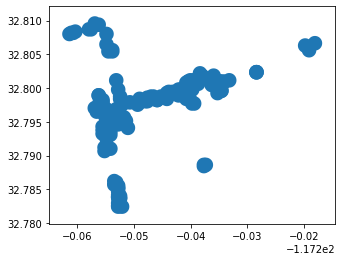

In [81]:
# Pacific Beach

clusters.to_crs(4326).cx[-117.26:-117.22,32.78:32.82].plot()



In [17]:
sd_points.to_file('business_points_clusters.geojson', driver='GeoJSON')
clusters.to_file('business_bubble_clusters.geojson', driver='GeoJSON')
bc.to_file('business_clusters.geojson', driver='GeoJSON')